# 신경망 모델 훈련

케라스 API를 이용해서 모델 훈련하는 다양한 도구 및 개념 살펴보기

## 손실 곡선

`<tensorflow.python.keras.callbacks.History at 0x7fef38bfc080>`

fit() 메서드의 실행 결과로 Histroy 객체를 반환한다. 이를 이용해서 그래프를 그려보자

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [2]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer) # a_layer로 레이어를 추가하면 추가하기
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [3]:
model = model_fn()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=5, verbose=0)
print(model.fit(train_scaled, train_target, epochs=5, verbose=0))

In [5]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


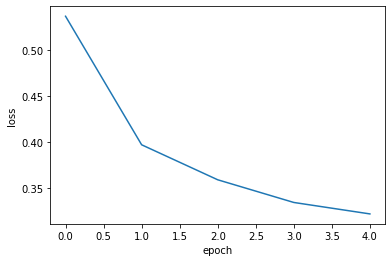

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

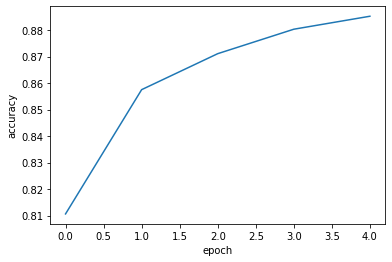

In [7]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [8]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

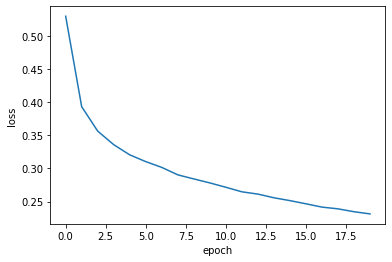

In [9]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

In [10]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


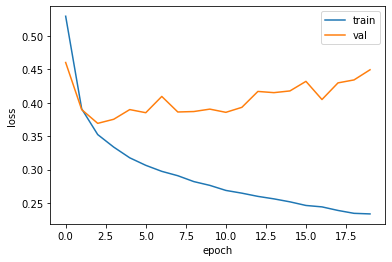

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [13]:
# 오버피팅 막기 위한 규제 추가
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

adam 규제 시각화
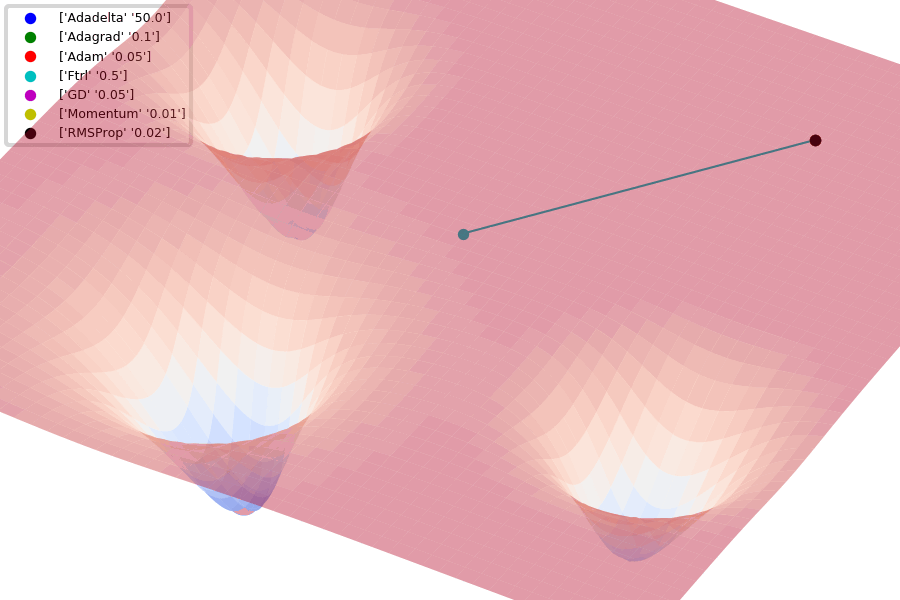

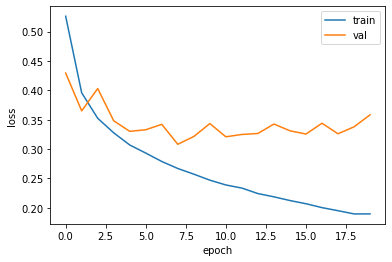

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 드롭아웃

![](https://kh-kim.github.io/nlp_with_deep_learning_blog/assets/images/1-14/04-dropout_overview.png)   
특정 뉴런의 과대의존을 줄일 수 있고 안정적인 예측을 만들 수 있다.

In [15]:
model = model_fn(keras.layers.Dropout(0.3)) # 30% dropout

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


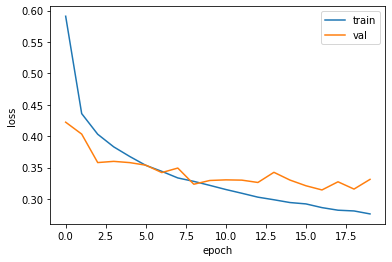

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델 저장과 복원

In [17]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [18]:
# 모델의 가중치 저장
model.save_weights('model-weights.h5')

In [19]:
# 모델 전체 저장
model.save('model-whole.h5')

In [20]:
!ls -al *.h5

-rw-r--r-- 1 root root 981736 Jan 26 06:28 best-model.h5
-rw-r--r-- 1 root root 332480 Jan 26 08:53 model-weights.h5
-rw-r--r-- 1 root root 981736 Jan 26 08:53 model-whole.h5


In [21]:
model = model_fn(keras.layers.Dropout(0.3))

# load하려면 저장했던 구조 그대로 세팅한다음 불러와야한다.
model.load_weights('model-weights.h5')

In [22]:
import numpy as np

# np.argmax()는 배열에서 가장 큰 값을 가진 인덱스를 반환한다.
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8824166666666666


In [23]:
print(val_scaled.shape)
print(val_target.shape)

(12000, 28, 28)
(12000,)


In [24]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3288 - accuracy: 0.8824


[0.32880687713623047, 0.8824166655540466]

## 콜백
훈련 과정중에 어떤 작업을 수행할 수 있게 하는 객체다.

In [25]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
# ModelCheckpoint()는 에포크마다 모델을 저장 

model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [26]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3230 - accuracy: 0.8844


[0.3229566216468811, 0.8844166398048401]

In [27]:
# 에포크 20번 학습이 불필요해서 early stopping 추가하기

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
# patience는 2에포크만큼 향상되지 않으면 조기종료

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [28]:
print(early_stopping_cb.stopped_epoch)

7


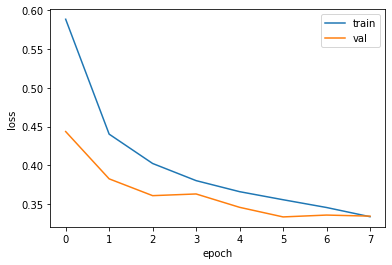

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [30]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3335 - accuracy: 0.8763


[0.3334736227989197, 0.8763333559036255]